# 1. Cross Validation

## 1.1 cross_val_score() in sklearn

**`cross_val_score` 是聪明的**，它会自动根据任务类型选用合适的交叉验证策略：

- 分类 ➜ `StratifiedKFold`
- 回归 ➜ `KFold`

### 1.1.1 cross_val_score() for kfold

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [3]:
X_reg, y_reg = load_diabetes(return_X_y = True)
reg_model = LinearRegression()
reg_scores = cross_val_score(reg_model, X_reg, y_reg, cv=5, scoring="neg_mean_squared_error") #cv=kfold or stratified to explicitely, 
#only number cv=5, then cross_val_score will determin use which determine on regression or classification

In [4]:
print("每折 MSE:", reg_scores)
print("平均 MSE:", reg_scores.mean())

每折 MSE: [-2779.92344921 -3028.83633883 -3237.6875877  -3008.74648884
 -2910.21268776]
平均 MSE: -2993.08131046933


### 1.1.2 cross_val_score() for stratifiedkfold

In [5]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [6]:
X_clf, y_clf = load_iris(return_X_y=True)
clf_model = SVC(kernel="linear")
clf_scores = cross_val_score(clf_model, X_clf, y_clf, cv=5, scoring="accuracy")

In [8]:
print("每折准确率:", clf_scores)
print("平均准确率:", clf_scores.mean())

每折准确率: [0.96666667 1.         0.96666667 0.96666667 1.        ]
平均准确率: 0.9800000000000001


## 1.2 Kfold in sklearn

In [9]:
n_samples = len(X_reg)

In [16]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(X_reg))

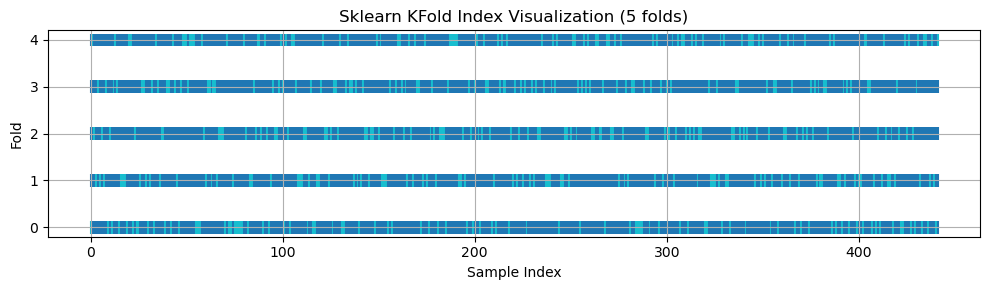

In [18]:
#visualize index in each fold

fig, ax = plt.subplots(figsize=(10, 3))
for fold, (train_idx, val_idx) in enumerate(splits):
    y_fold = np.full(n_samples, -1) #initialize to -1 for non-selected
    y_fold[val_idx] = fold
    ax.scatter(range(n_samples), [fold] * n_samples, c=y_fold, cmap="tab10", marker="|", s=80)

ax.set_title("Sklearn KFold Index Visualization (5 folds)")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Fold")
ax.set_yticks(range(5))
plt.tight_layout()
plt.grid(True)
plt.show()

## 1.3 StratifiedKFold in sklearn

In [23]:
from sklearn.model_selection import StratifiedKFold

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(X_clf, y_clf))

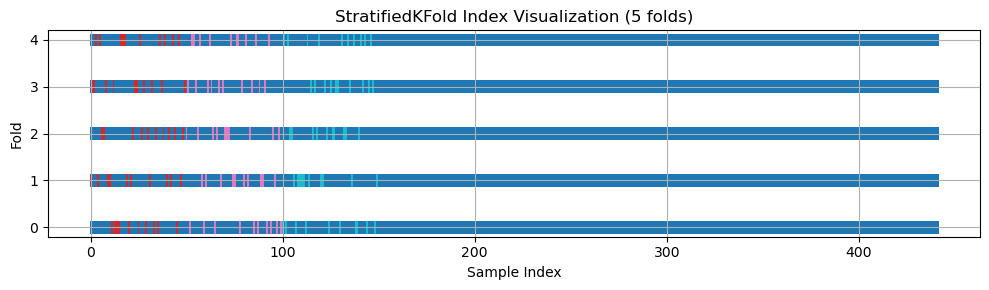

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))
for fold, (train_idx, val_idx) in enumerate(splits):
    y_vis = np.full(n_samples, -1)         # 所有样本初始为 -1，表示未参与验证集
    y_vis[val_idx] = y_clf[val_idx]            # 验证集标记为其类别标签（用于上色）

    ax.scatter(range(n_samples),           # 横轴为样本索引
               [fold] * n_samples,         # 每一行对应一个 fold
               c=y_vis,                    # 按照类别标签上色
               cmap="tab10", marker='|', s=80)

ax.set_title("StratifiedKFold Index Visualization (5 folds)")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Fold")
ax.set_yticks(range(5))
plt.tight_layout()
plt.grid(True)
plt.show()

## 1.4 KFold numpy

In [28]:
import numpy as np

In [34]:
def kfold_indices(n_samples, n_splits=5, shuffle=True, random_state=None):
    """
    手动实现 KFold 的索引生成器。

    参数：
    - n_samples: 样本数量（整数）
    - n_splits: 折数
    - shuffle: 是否在切分前打乱样本顺序
    - random_state: 随机种子，便于结果复现

    返回：
    - 生成器：每次 yield 一个 (train_idx, val_idx) 元组
    """
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.RandomState(random_state)
        rng.shuffle(indices) #shuffle the indices

    # 确定每一折的大小（如果不能整除，前面若干折多一个样本）
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1 #eg 442 samples, for each val size is [89, 89, 88, 88, 88], then train is [353, 353, 354, 354, 354]

    current = 0
    for fold_size in fold_sizes:
        val_idx = indices[current : current + fold_size]
        train_idx = np.concatenate([indices[:current], indices[current + fold_size:]]) # add :current (before val set) + current + fold_size: (after val set)
        yield train_idx, val_idx
        current += fold_size

In [35]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

n_samples = len(X)
print(n_samples)
kf = kfold_indices(n_samples, n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf):
    print(f"Fold {i+1}:")
    print(f"  Train size: {len(train_idx)} | Val size: {len(val_idx)}")
    print(f"  Train indices: {train_idx[:5]}...")  # 显示前5个
    print(f"  Val indices:   {val_idx[:5]}...")
    print("-" * 40)

442
Fold 1:
  Train size: 353 | Val size: 89
  Train indices: [ 17  66 137 245  31]...
  Val indices:   [287 211  72 321  73]...
----------------------------------------
Fold 2:
  Train size: 353 | Val size: 89
  Train indices: [287 211  72 321  73]...
  Val indices:   [ 17  66 137 245  31]...
----------------------------------------
Fold 3:
  Train size: 354 | Val size: 88
  Train indices: [287 211  72 321  73]...
  Val indices:   [250  59 111 204 410]...
----------------------------------------
Fold 4:
  Train size: 354 | Val size: 88
  Train indices: [287 211  72 321  73]...
  Val indices:   [274 164 136 197 258]...
----------------------------------------
Fold 5:
  Train size: 354 | Val size: 88
  Train indices: [287 211  72 321  73]...
  Val indices:   [212 295 403 251 431]...
----------------------------------------


### 1.5 StratifiedKFold numpy

In [39]:
def stratified_kfold_indices(y, n_splits=5, shuffle=True, random_state=None):
    """
    手动实现 StratifiedKFold 的索引生成器，保持每一折中类别分布比例一致。

    参数：
    - y: 标签数组（1D），支持多类别分类
    - n_splits: 折数
    - shuffle: 是否在切分前打乱每类样本顺序
    - random_state: 随机种子

    返回：
    - 一个生成器，yield (train_idx, val_idx)
    """

    y = np.array(y)
    n_samples = len(y)

    classes, y_indices = np.unique(y, return_inverse=True) # the returned y_indices is map the y element to class name, kind of like encode
    n_classes = len(classes)

    rng = np.random.RandomState(random_state)

    per_class_indices = [np.where(y_indices == class_idx)[0] for class_idx in range(n_classes)] # will generate [[indices for class 0], [indices for class[1], ...]]


    fold_indices = [[] for _ in range(n_splits)]

    for class_indices in per_class_indices:
        if shuffle:
            rng.shuffle(class_indices)

        fold_sizes = np.full(n_splits, len(class_indices) // n_splits, dtype=int)
        fold_sizes[:len(class_indices) % n_splits] += 1

        current = 0
        for fold in range(n_splits):
            start, stop = current, current + fold_sizes[fold]
            fold_indices[fold].extend(class_indices[start : stop])
            current = stop


    for fold in range(n_splits):
        val_idx = np.array(fold_indices[fold])
        train_idx = np.array([i for i in range(n_samples) if i not in val_idx])
        yield train_idx, val_idx

In [41]:
from sklearn.datasets import load_iris

# 加载分类数据
X, y = load_iris(return_X_y=True)
print(f"X len: {len(X)}")

# 获取分层索引
splits = stratified_kfold_indices(y, n_splits=5, shuffle=True, random_state=42)

# 打印每一折验证集的类别分布
for i, (_, val_idx) in enumerate(splits):
    unique, counts = np.unique(y[val_idx], return_counts=True)
    print(f"Fold {i+1}: {dict(zip(unique, counts))}")

X len: 150
Fold 1: {0: 10, 1: 10, 2: 10}
Fold 2: {0: 10, 1: 10, 2: 10}
Fold 3: {0: 10, 1: 10, 2: 10}
Fold 4: {0: 10, 1: 10, 2: 10}
Fold 5: {0: 10, 1: 10, 2: 10}


## 1.6 Cross_val_score numpy

In [42]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score, mean_squared_error

In [45]:
def cross_val_score_numpy(model, X, y, cv_generator, scoring="accuracy"):
    """
    使用 NumPy 实现的 cross_val_score，支持回归和分类。

    参数：
    - model: 支持 fit 和 predict 的模型（sklearn）
    - X: 特征数组，形状 (n_samples, n_features)
    - y: 标签数组，形状 (n_samples,)
    - cv_generator: 由 KFold 或 StratifiedKFold 返回的索引生成器
    - scoring: 'accuracy' 或 'neg_mean_squared_error'

    返回：
    - 每一折的评分列表（np.array）
    """

    scores = []

    for fold, (train_idx, val_idx) in enumerate(cv_generator):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_val)

        if scoring == 'accuracy':
            score = accuracy_score(y_val, y_pred)
            #score = np.sum(y_val == y_pred) / len(y_val)
        elif scoring == 'neg_mean_squared_error':
            score = -mean_squared_error(y_val, y_pred)
            #score = score = -np.mean((y_val - y_pred) ** 2)

        scores.append(score)

    return np.array(scores)

In [51]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)
model = LogisticRegression(max_iter=1000)

# 手动 StratifiedKFold（我们之前实现的函数）
cv_gen = stratified_kfold_indices(y, n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score_numpy(model, X, y, cv_gen, scoring='accuracy')
print("每一折的准确率:", scores)
print("平均准确率:", scores.mean())

每一折的准确率: [1.         0.96666667 0.96666667 0.93333333 0.96666667]
平均准确率: 0.9666666666666668


In [52]:
scores = cross_val_score_numpy(model, X, y, KFold(n_splits=5, shuffle=True, random_state=42).split(X), scoring='accuracy')
print("每一折的准确率:", scores)
print("平均准确率:", scores.mean())

每一折的准确率: [1.         1.         0.93333333 0.96666667 0.96666667]
平均准确率: 0.9733333333333334


In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(max_iter=1000)
cv_gen = skf.split(X, y)  # 注意：必须传入 y 用于分层

scores = cross_val_score_numpy(model, X, y, cv_gen, scoring='accuracy')
print("StratifiedKFold accuracy:", scores.mean())

StratifiedKFold accuracy: 0.9666666666666668


In [56]:
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("StratifiedKFold accuracy:", scores.mean())

StratifiedKFold accuracy: 0.9733333333333334


In [58]:
cv_gen = kfold_indices(len(X), n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score_numpy(model, X, y, cv_gen, scoring='accuracy')
print("StratifiedKFold accuracy:", scores.mean())

StratifiedKFold accuracy: 0.9733333333333334


# 2. GridSearchCV

## 2.1 Sklearn gridsearchcv

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
# 加载数据
X, y = load_iris(return_X_y=True)

# 定义模型和搜索空间
model = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# 设置 GridSearchCV（默认 StratifiedKFold）
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    return_train_score=True
)

# 执行搜索
grid_search.fit(X, y)

# 输出最优结果
print("最优参数:", grid_search.best_params_)
print("最优分数:", grid_search.best_score_)

最优参数: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
最优分数: 0.9800000000000001


In [63]:
import pandas as pd

# 将交叉验证结果转为 DataFrame 查看细节
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
4,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.980000,0.016330,1
6,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}",0.980000,0.016330,1
7,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.980000,0.016330,1
9,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.980000,0.016330,1
11,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.980000,0.016330,1
0,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.973333,0.013333,6
2,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.973333,0.013333,6
8,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.973333,0.038873,6
10,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",0.973333,0.038873,6
5,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.966667,0.021082,10


## 2.2 numpy grid search cv

In [64]:
from itertools import product

In [65]:
def grid_search_cv(model, X, y, param_grid, cv_generator, scoring="accuracy"):

    """
    使用 NumPy 手动实现的 GridSearchCV。
    
    参数：
    - model: 拟合模型（如 SVC）
    - X, y: 数据集
    - param_grid: dict，超参数搜索空间
    - cv_generator: KFold 或 StratifiedKFold 的 .split(X, y) 生成器
    - scoring: 支持 'accuracy'（分类）

    返回：
    - results_df: DataFrame，每组参数组合及其平均分数
    - best_params: 平均得分最高的参数组合
    """

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    results = []
    for params in param_combinations:
        cv = list(cv_generator)
        scores = []
        for train_idx, val_idx in cv:
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            # 克隆模型并设置参数
            m = clone(model).set_params(**params)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_val)

            # 计算评分
            if scoring == 'accuracy':
                score = accuracy_score(y_val, y_pred)
            elif scoring == 'neg_mean_squared_error':
                score = -mean_squared_error(y_val, y_pred)

            scores.append(score)

        avg_score = np.mean(scores)
        results.append({**params, 'mean_score': avg_score})

    # 转为 DataFrame，找到最优参数
    results_df = pd.DataFrame(results)
    best_idx = results_df['mean_score'].idxmax()
    best_params = results_df.iloc[best_idx][list(keys)].to_dict()

    return results_df, best_params

In [67]:
# 加载数据
X, y = load_iris(return_X_y=True)

# 模型与超参数空间
model = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# 交叉验证折叠生成器（sklearn 的也可直接用）
cv_generator = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y)

# 手动 GridSearchCV
results_df, best_params = grid_search_cv(model, X, y, param_grid, cv_generator, scoring='accuracy')

print("Best Parameters:", best_params)
print(results_df)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
      C  kernel  mean_score
0   0.1  linear    0.973333
1   0.1     rbf         NaN
2   1.0  linear         NaN
3   1.0     rbf         NaN
4  10.0  linear         NaN
5  10.0     rbf         NaN


/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_grid_heatmap(results_df, x_param, y_param, score_param='mean_score'):
    """
    绘制手动 GridSearchCV 的评分热力图。

    参数：
    - results_df: DataFrame，包含超参数组合与评分
    - x_param: 横轴参数名（如 'C'）
    - y_param: 纵轴参数名（如 'kernel'）
    - score_param: 默认使用 'mean_score' 作为热力图的值
    """
    # 转换成透视表（参数组合 -> 分数）
    pivot_table = results_df.pivot(index=y_param, columns=x_param, values=score_param)

    # 绘图
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"Grid Search Mean Score Heatmap ({score_param})")
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.tight_layout()
    plt.show()


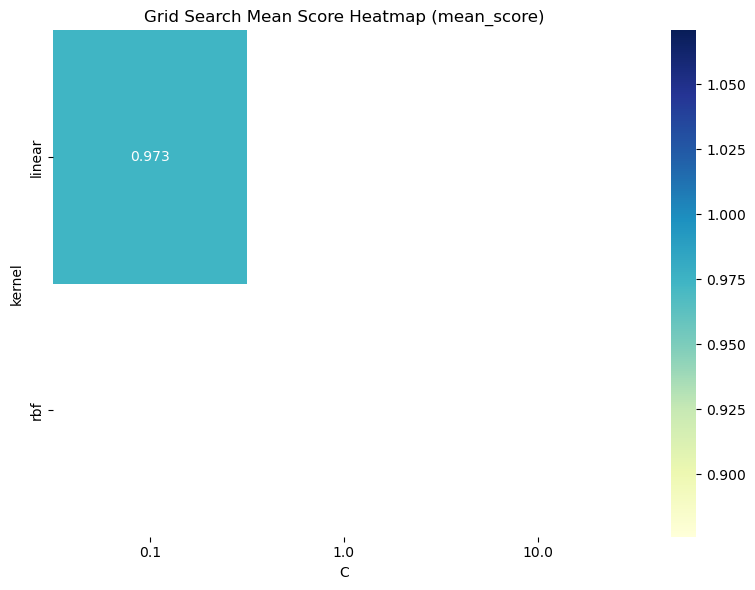

In [69]:
plot_grid_heatmap(results_df, x_param='C', y_param='kernel')

# 3. Ensemble learning basics

## 3.1 Bagging, Eg. Random forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

X, y = load_iris(return_X_y=True)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X, y, cv=5)
print(f"Random Forest Accuracy (5-fold): {scores.mean():.3f}")

Random Forest Accuracy (5-fold): 0.967


In [72]:
scores = cross_val_score_numpy(rf, X, y, StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))
print(f"Random Forest Accuracy (5-fold): {scores.mean():.3f}")

Random Forest Accuracy (5-fold): 0.947


In [78]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class RandomForestClassifierScratch:
    def __init__(self, n_estimators=10, max_features='sqrt', max_depth=None, bootstrap=True, random_state=None):
        """
        简单版随机森林分类器（基于 sklearn 的决策树）

        参数说明：
        - n_estimators: 森林中树的数量
        - max_features: 每棵树使用的特征数量（'sqrt'、'log2' 或 int）
        - max_depth: 决策树最大深度
        - bootstrap: 是否对样本有放回采样
        - random_state: 随机种子（保证结果可复现）
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []
        self.features_indices = []

        if random_state is not None:
            np.random.seed(random_state)

    def _sample(self, X, y):
        """
        样本采样 + 特征采样

        返回：
        - X_sample: 采样后的特征
        - y_sample: 采样后的标签
        - features: 使用的特征索引
        """
        n_samples, n_features = X.shape

        # 对样本有放回采样
        indices = np.random.choice(n_samples, size=n_samples, replace=self.bootstrap)

        # 选择特征数量
        if self.max_features == 'sqrt':
            max_feats = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_feats = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            max_feats = self.max_features
        else:
            max_feats = n_features

        # 随机选择特征索引
        features = np.random.choice(n_features, size=max_feats, replace=False)

        return X[indices][:, features], y[indices], features

    def fit(self, X, y):
        """
        拟合训练数据，构建多棵决策树
        """
        self.trees = []
        self.features_indices = []
        self.classes_ = np.unique(y)

        for _ in range(self.n_estimators):
            X_sample, y_sample, feat_idx = self._sample(X, y)
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self.features_indices.append(feat_idx)

    def predict(self, X):
        """
        多数投票进行预测
        """
        predictions = np.zeros((X.shape[0], self.n_estimators), dtype=int)

        for i, tree in enumerate(self.trees):
            features = self.features_indices[i]
            preds = tree.predict(X[:, features])
            predictions[:, i] = preds

        # 对每一行做多数投票
        y_pred = []
        for row in predictions:
            counts = np.bincount(row)
            y_pred.append(np.argmax(counts))
        return np.array(y_pred)

    def predict_proba(self, X):
        """
        输出每个样本属于每个类别的概率（每棵树的投票占比）
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        proba = np.zeros((n_samples, n_classes))

        for tree, feat_idx in zip(self.trees, self.features_indices):
            preds = tree.predict(X[:, feat_idx])
            for i, pred in enumerate(preds):
                class_idx = np.where(self.classes_ == pred)[0][0]
                proba[i, class_idx] += 1

        # 转为概率（归一化）
        proba /= self.n_estimators
        return proba

In [79]:
X, y = load_iris(return_X_y=True)

rf = RandomForestClassifierScratch(n_estimators=10, max_depth=3, random_state=42)
rf.fit(X, y)
y_pred = rf.predict(X)

print("预测前10个：", y_pred[:10])

预测前10个： [0 0 0 0 0 0 0 0 0 0]


In [81]:
y_prob = rf.predict_proba(X)

In [82]:
y_prob

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. 

## 3.2 VotingClassifier

In [83]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 多个基分类器
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = SVC(probability=True)

# 投票集成器（soft voting）
voting = VotingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3)],
    voting='soft'
)

scores = cross_val_score(voting, X, y, cv=5)
print(f"VotingClassifier Accuracy (soft): {scores.mean():.3f}")

VotingClassifier Accuracy (soft): 0.973


/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
